## Python-gmt Test with FOCI Data from ERDDAP
### erddapy example for PMEL tools - Shiptracks

***erddapy requires python 3.6*** for passing time information (pandas datetime to timestamp doesn't appear to work in 2.7)
***gmt-python requires python 3.6***

### connecting and basic information

In [69]:
from erddapy import ERDDAP
import pandas as pd
import numpy as np

server_url='http://krafla.pmel.noaa.gov:8080/erddap'
e = ERDDAP(server=server_url)

Get only ARGOS Drifter datafiles

In [70]:
df = pd.read_csv(e.get_search_url(response='csv', search_for='argos'))

In [71]:
argos = df['Dataset ID'].values
print(argos)

['2015_Argos_Drifters' '2016_Argos_Drifters' '2017_Argos_Drifters'
 '2018_Argos_Drifters']


In [79]:
kw = {
    'standard_name': 'sea_water_temperature',
    'min_lon': 0,
    'max_lon': 540,
    'min_lat': 50.0,
    'max_lat': 90.0,
    'min_time': '2015-01-10T00:00:00Z',
    'max_time': '2019-01-10T00:00:00Z',
    'cdm_data_type': 'trajectory'
}

In [80]:
variables = [e.get_var_by_attr(dataset_id=float, long_name=lambda v: v is not None) for float in argos]

In [81]:
common_variables = set(variables[0]).intersection(*variables[1:])

common_variables.update(['trajectory_id']) 
common_variables

{'latitude', 'longitude', 'sst', 'strain', 'time', 'trajectory_id', 'voltage'}

In [82]:
constraints = {
    'longitude>=': kw['min_lon'],
    'longitude<=': kw['max_lon'],
    'latitude>=': kw['min_lat'],
    'latitude<=': kw['max_lat'],
    'time>=': kw['min_time'],
    'time<=': kw['max_time'],
}

download_url = e.get_download_url(
    dataset_id=argos[0],
    protocol='tabledap',
    response='csv',
    variables=common_variables,
    constraints=constraints
)

print(download_url)

http://krafla.pmel.noaa.gov:8080/erddap/tabledap/2015_Argos_Drifters.csv?longitude,sst,voltage,strain,trajectory_id,time,latitude&longitude>=0&longitude<=540&latitude>=50.0&latitude<=90.0&time>=1420848000.0&time<=1547078400.0


In [83]:
from requests.exceptions import HTTPError

dfs = {}
for float in argos:
    print(float)
    try:
        e = ERDDAP(server=server_url,
            dataset_id=float,
            protocol='tabledap',
            response='csv',
            variables=common_variables,
            constraints=constraints
        )

        dfs.update({float: e.to_pandas(
                            index_col='time',
                            parse_dates=True,
                            skiprows=(1,)  # units information can be dropped.
                            )})
    except HTTPError:
        print('Failed to generate url {}'.format(float))
        continue


2015_Argos_Drifters
2016_Argos_Drifters
2017_Argos_Drifters
2018_Argos_Drifters


In [84]:
for float, df in dfs.items():
    print(float, df.groupby('trajectory_id').groups.keys())

2015_Argos_Drifters dict_keys([122533, 122537, 122542, 122843, 122845, 122846, 122847, 136859, 136860, 136861, 136862, 136863, 136864, 136865, 136866, 136867, 136868, 136869, 136870, 136871, 136873, 136874, 148276, 148277, 148278, 148279])
2016_Argos_Drifters dict_keys([136861, 136864, 136865, 136872, 136874, 148276, 148277, 148279])
2017_Argos_Drifters dict_keys([122537, 122540, 122541, 122542, 136860, 136863, 136866, 136867, 136868, 136869, 136872, 145474, 148276, 148277])
2018_Argos_Drifters dict_keys([136863, 136866, 136867, 145474])


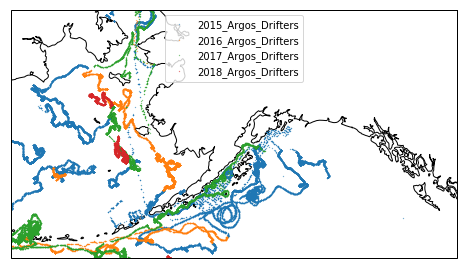

In [85]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(8, 8),
                           subplot_kw=dict(projection=projection))
    if projection == ccrs.PlateCarree():
        gl = ax.gridlines(draw_labels=True)
        gl.xlabels_top = gl.ylabels_right = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

projection=ccrs.LambertConformal(central_longitude=-160.0)
transformation=ccrs.PlateCarree()

land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='1.0')

dx = dy = 0.5
extent = -180, -130, kw['min_lat']+dy, kw['max_lat']+dy
extent = [-180, -130, 50, 66]
fig,ax = make_map(projection=projection)
for float, df in dfs.items():
    ax.plot(df['longitude'], df['latitude'], '.', markersize=0.5, label=float, transform=transformation)

leg = ax.legend()

ax.add_feature(land_50m)
ax.coastlines(resolution='50m')
ax.set_extent(extent)

### Testing gmt-python as alternative plotting platform over cartopy or basemap

In [86]:
import gmt

In [87]:
fig = gmt.Figure()


fig.coast(region=[-180, -140, 50, 80], projection='B-160/60/55/60/6i', land='lightgray', water='gray',
          frame=True,U=True)

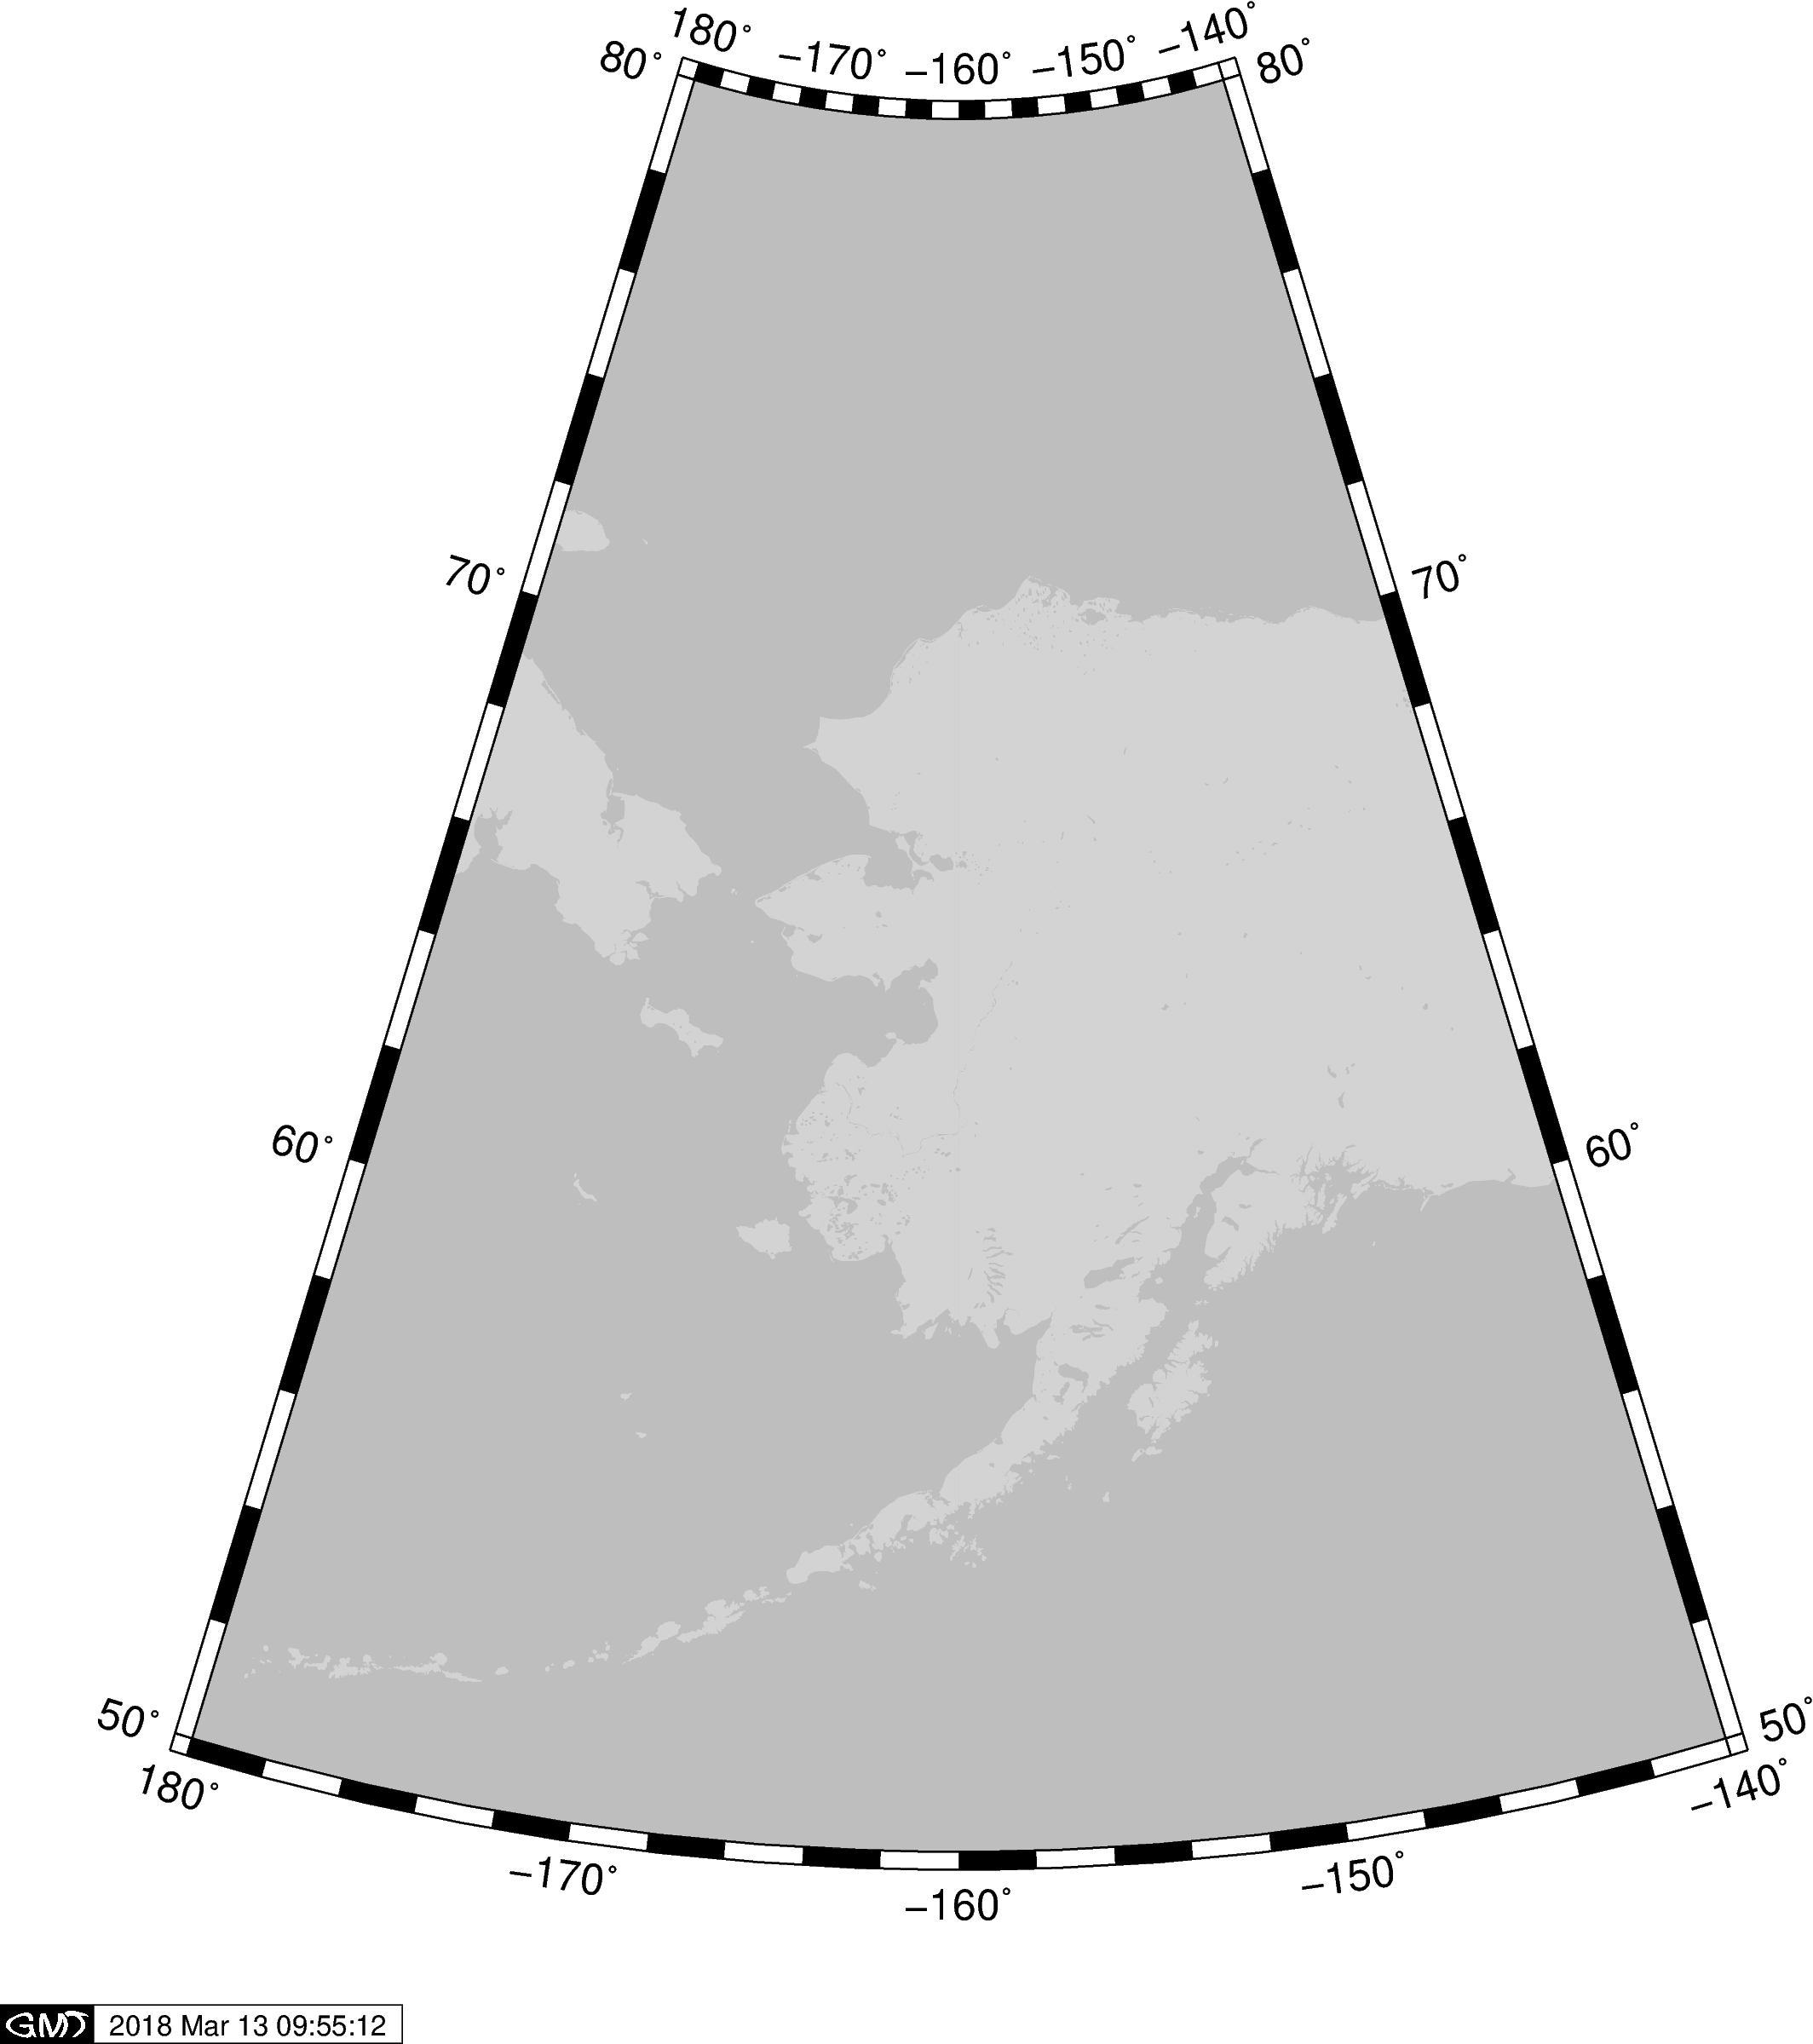

In [88]:
fig.show()

In [89]:
clist=['red','black','blue','green','cyan','yellow','orange','lightred']
count=0
for ship, df in dfs.items():
    fig.plot(x=df.longitude, y=df.latitude, color=clist[count], style='p0.05')
    print(clist[count])
    count+=1

red
black
blue
green


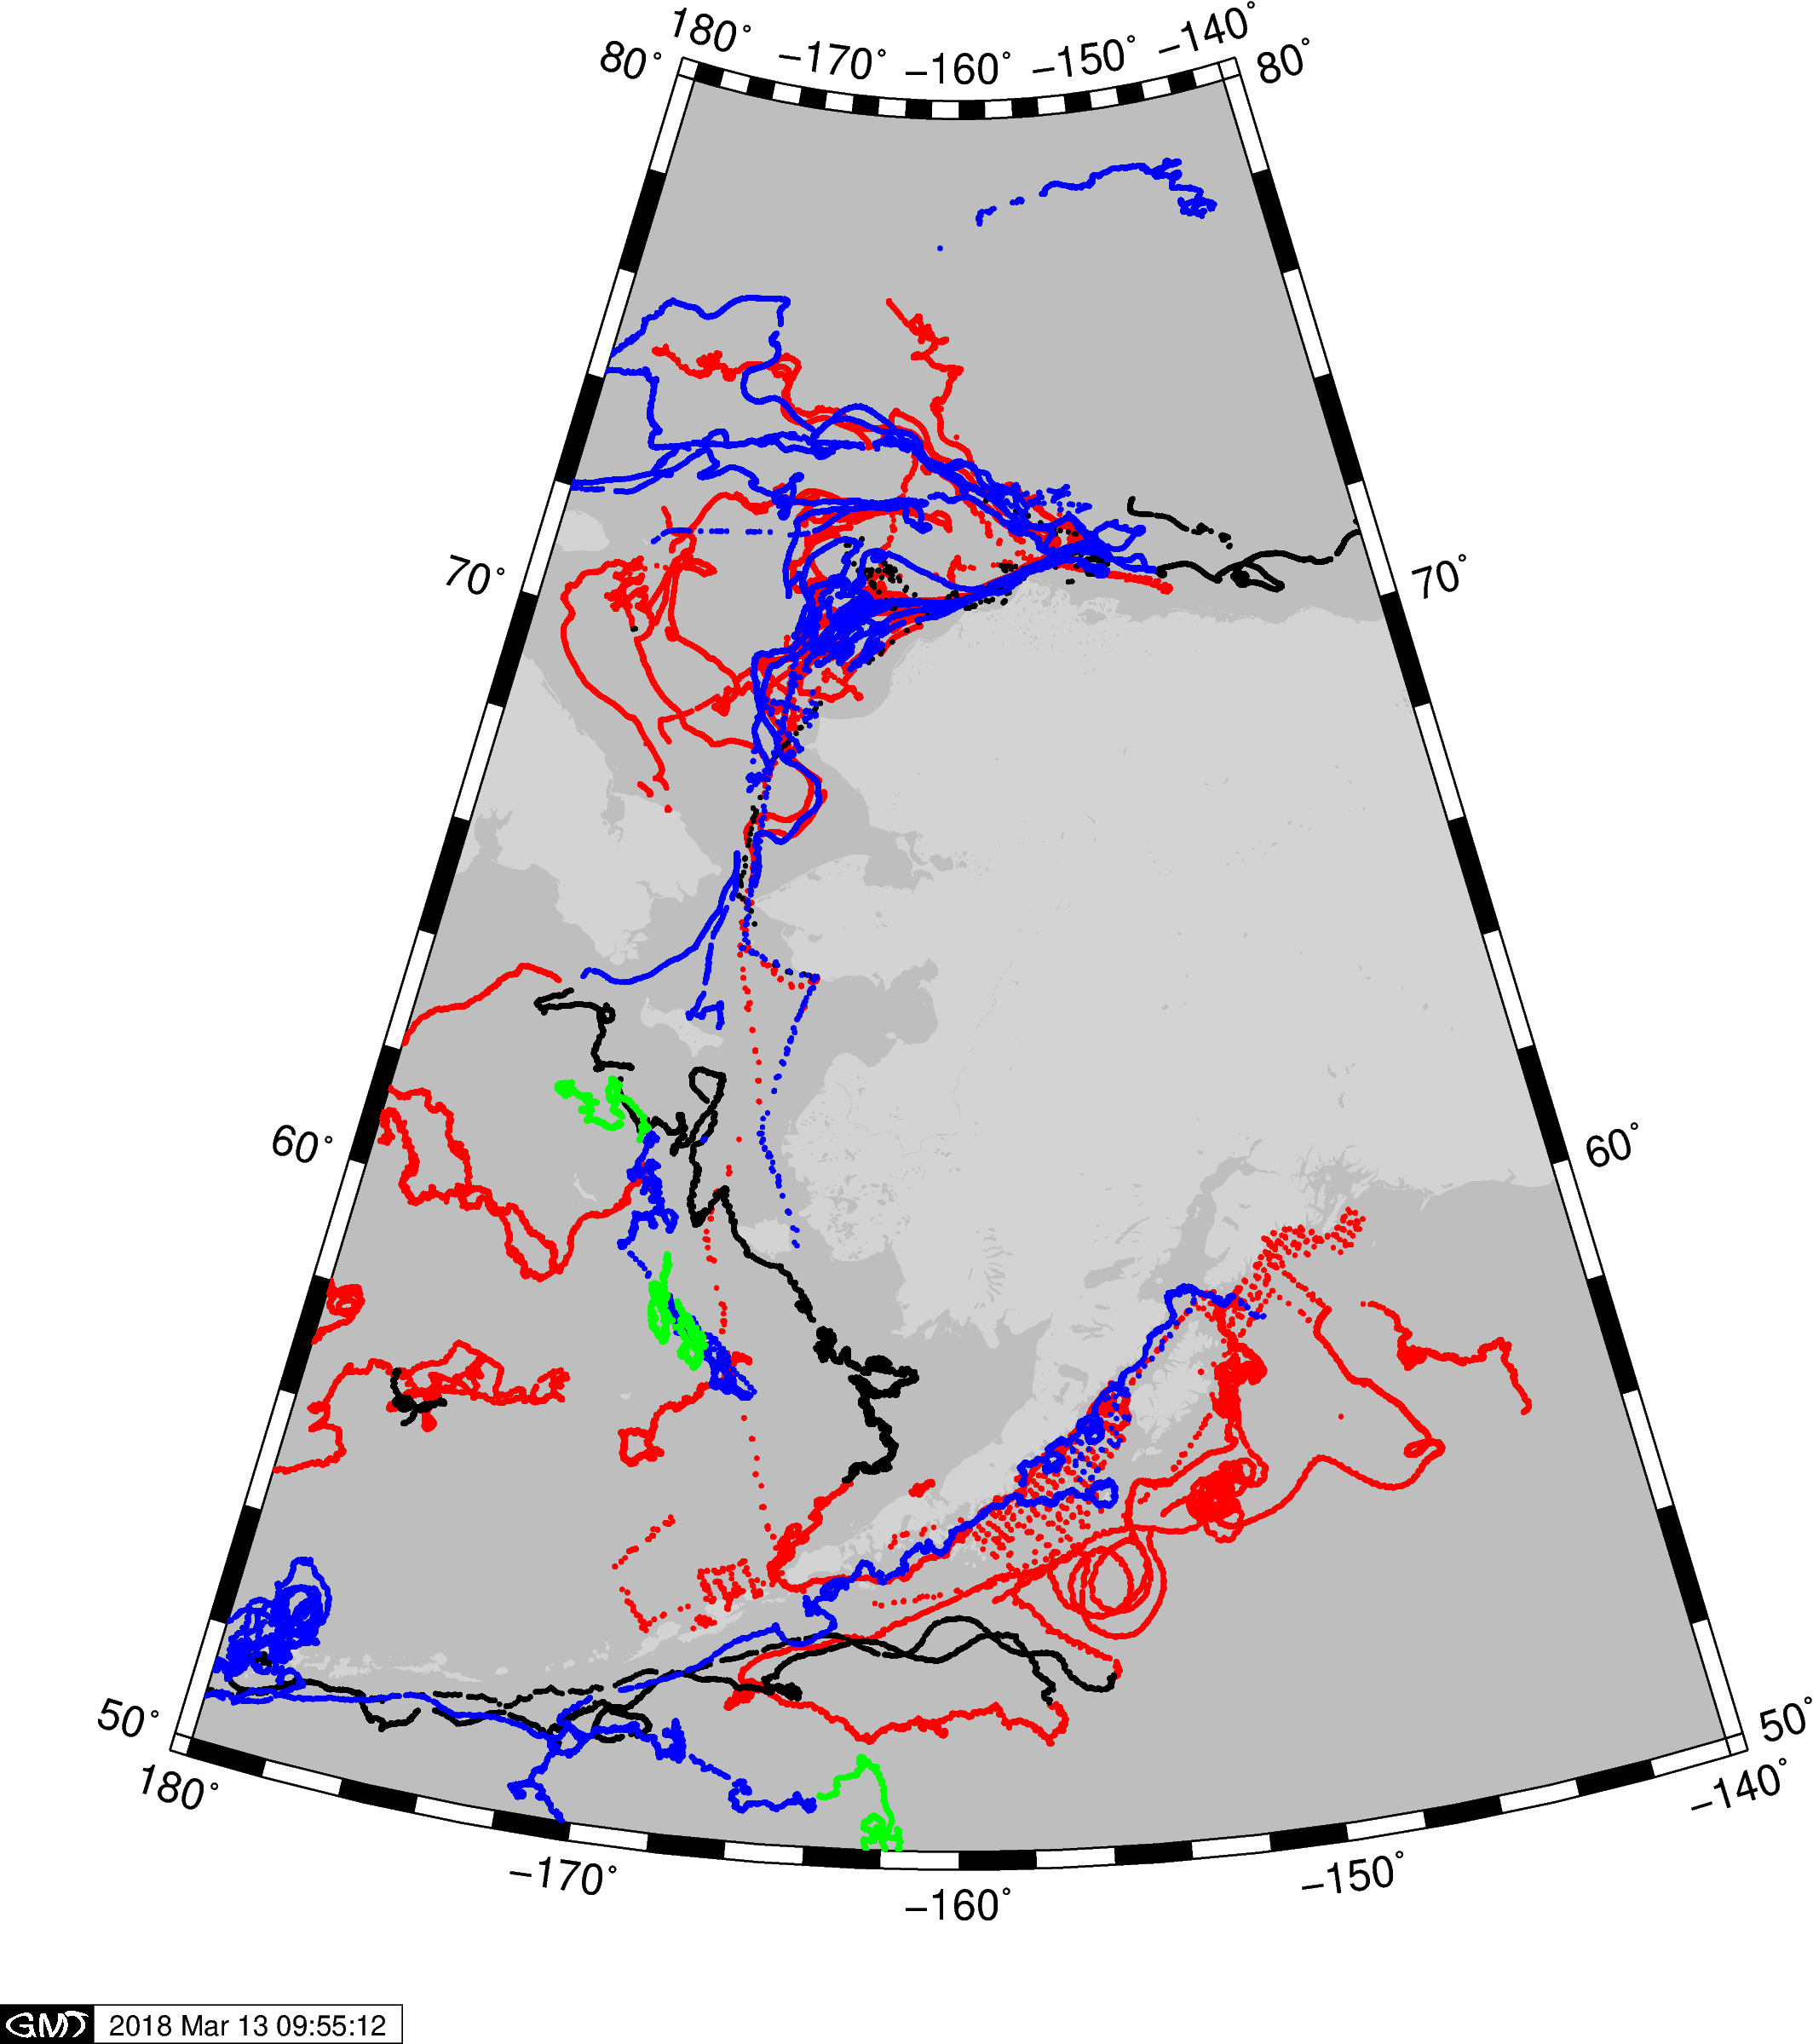

In [90]:
fig.show()